## Compute the change in distance of the cusp closest to (0, 0) as a function of planet ratio and small planet seperation, $s_{small}$

In [91]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import time as t

import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import sklearn as sk

import matplotlib.patches as patches
import matplotlib.collections as collections

import VBMicrolensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializing VBMicrolensing

In [92]:
VBM = VBMicrolensing.VBMicrolensing()

# Set relative accuracy
VBM.RelTol = 1e-03

# Set accuracy
VBM.Tol=1e-03

## Defining binary lens attributes and finding the most optimal angular width and thickness to find all central caustics

In [93]:
# Big planet position
s1 = 0.3
alpha1 = 0

# Small planet position
s2 = s1
alpha2 = 30

# Big planet / star mass ratio
q_big = 1e-3

# Planet mass ratio
mass_ratios = np.linspace(0, 1, int(1e3)).reshape(int(1e3), 1)

# print(mass_ratios)

# Defining binary lens parameters
binary_lens_attributes = [0, 0, 1,
                          s1*np.cos(np.deg2rad(alpha1)), s1*np.sin(np.deg2rad(alpha1)), q_big]

# Probing mass space to see what the smallest mass detectable is
trinary_lens_attributes_list = []

for i in range(len(mass_ratios)):
    trinary = binary_lens_attributes.copy()
    trinary.extend(
        [s2*np.cos(np.deg2rad(alpha2)), s2*np.sin(np.deg2rad(alpha2)), mass_ratios[i] * q_big] # Small mass
    )

    trinary_lens_attributes_list.append(trinary)

## Iterating through all triple lens configurations and computing caustics

In [94]:
trinary_caustics_list  = []

for config in trinary_lens_attributes_list:
    VBM.SetLensGeometry(config)

    caustic_points = VBM.Multicaustics()
    for caus in caustic_points:
        if len(caus[0]) == 400:
            trinary_caustics_list.append(np.array(caus))

# print(trinary_caustics_list)

/var/folders/39/mb5cwg0x4h18n1y377g5rs9c0000gn/T/ipykernel_33268/137641.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  VBM.SetLensGeometry(config)


## Function to find all caustic cusps

In [95]:
def find_cusp_points(caustic_points):
    points = caustic_points.T  # Shape: (400, 2)

    vectors = np.diff(points, axis=0)  # Shape: (399, 2)

    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    unit_vectors = vectors / norms

    dot_products = np.sum(unit_vectors[:-1] * unit_vectors[1:], axis=1)
    dot_products = np.clip(dot_products, -1.0, 1.0)  # Clip to avoid numerical errors
    angles = np.rad2deg(np.arccos(dot_products))  # In degrees

    cusp_indices = np.where(angles > 50)[0] + 1  # +1 to shift to the index of the corner point

    return caustic_points[0, cusp_indices], caustic_points[1, cusp_indices]

## Iterating through all triple lens configurations and computing the deviation of central cusp from binary case (first case)

In [96]:
binary_caustic = trinary_caustics_list[0]

binary_xs, binary_ys = find_cusp_points(binary_caustic)
binary_distances = np.sqrt(binary_xs**2 + binary_ys**2)
binary_closest_idx = np.argmin(binary_distances)

binary_cusp_x, binary_cusp_y = binary_xs[binary_closest_idx], binary_ys[binary_closest_idx]

trinary_cusp_xs = np.zeros((len(trinary_caustics_list), 1))
trinary_cusp_ys = np.zeros((len(trinary_caustics_list), 1))

# trinary_cusp_rs = np.zeros((len(trinary_caustics_list), 1))
# trinary_cusp_thetas = np.zeros((len(trinary_caustics_list), 1))

for i, trinary_caustic in enumerate(trinary_caustics_list):
    trinary_xs, trinary_ys = find_cusp_points(trinary_caustic)
    trinary_distances = np.sqrt(trinary_xs**2 + trinary_ys**2)
    trinary_closest_idx = np.argmin(trinary_distances)

    trinary_cusp_xs[i] = trinary_xs[trinary_closest_idx]
    trinary_cusp_ys[i] = trinary_ys[trinary_closest_idx]

trinary_cusp_xs -= binary_cusp_x
trinary_cusp_ys -= binary_cusp_y

trinary_cusp_rs = np.sqrt(trinary_cusp_xs**2 + trinary_cusp_ys**2)
trinary_cusp_thetas = np.rad2deg(np.atan2(trinary_cusp_ys, trinary_cusp_xs))

In [97]:
print(mass_ratios.shape)
print(trinary_cusp_xs.shape)
# result = sci.stats.linregress(mass_ratios[1:], trinary_cusp_xs[1:])
model = sk.linear_model.LinearRegression()
model.fit(mass_ratios[1:], trinary_cusp_xs[1:])

print(model.coef_)
print(model.intercept_)
print(model.score(mass_ratios[1:], trinary_cusp_xs[1:]))

(1000, 1)
(1000, 1)
[[0.0001652]]
[1.76492623e-06]
0.9998211203034639


## Plotting deviation of central cusp from binary case as a function of planet mass ratio

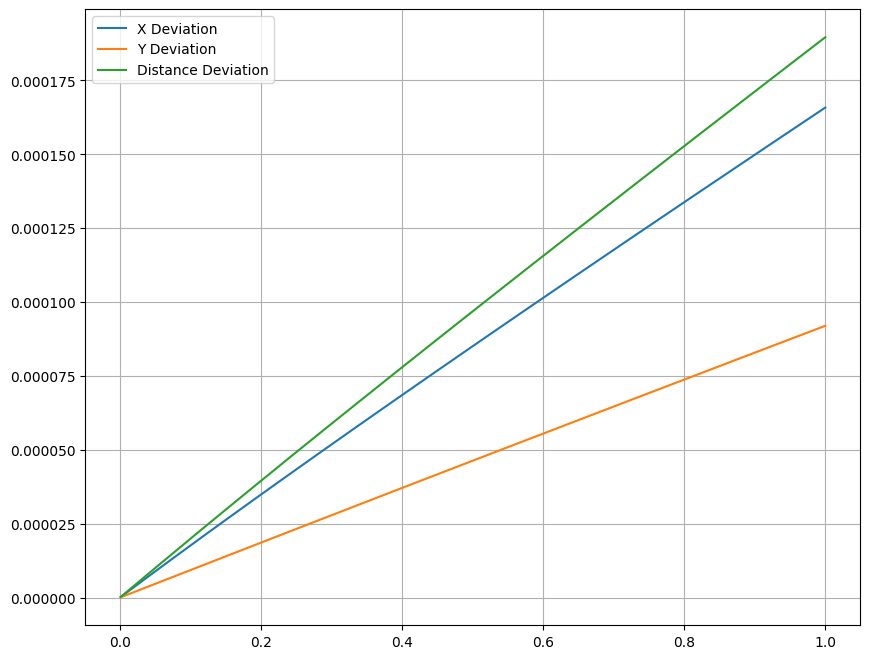

In [98]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(mass_ratios[1:], trinary_cusp_xs[1:], label='X Deviation')
ax.plot(mass_ratios[1:], trinary_cusp_ys[1:], label='Y Deviation')
ax.plot(mass_ratios[1:], trinary_cusp_rs[1:], label='Distance Deviation')

# ax.plot(mass_ratios[1:], trinary_cusp_thetas[1:], label='Angle Deviation')

ax.legend()
ax.grid()
# ax.plot(mass_ratios[1:], trinary_cusp_thetas[1:])

plt.show()

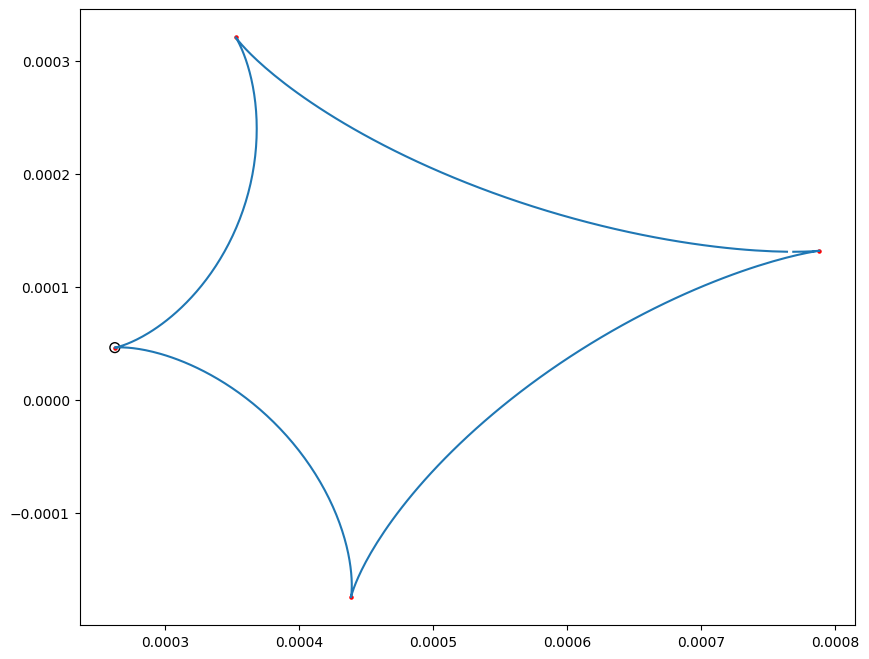

In [99]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# for trinary_caustic in trinary_caustics_list:
#     ax.plot(trinary_caustic[0, :], trinary_caustic[1, :])
ind = 500

trinary_xs, trinary_ys = find_cusp_points(trinary_caustics_list[ind])

ax.plot(trinary_caustics_list[ind][0, :], trinary_caustics_list[ind][1, :])
ax.scatter(trinary_cusp_xs[ind] + binary_cusp_x, trinary_cusp_ys[ind] + binary_cusp_y, s=50, color='black', marker='o', facecolor='none')
ax.scatter(trinary_xs, trinary_ys, s=20, color='red', marker='.')

plt.show()